# Embeddings Overview

In [13]:
!pip install torch torchvision seaborn tqdm

You should consider upgrading via the '/Users/leandro/Library/Caches/pypoetry/virtualenvs/whylogs-vWIOXmxX-py3.8/bin/python -m pip install --upgrade pip' command.


## Image Drift 

Image data can drift in a multitude of ways. Due to its intrepetive and contextual nature image data pipelines can fail and drift in extremelly unexpected ways. Having control of how and where data is created can subtantially minimizes these problems. However, this sometimes require a tight control of instrumentation and enviroment where image are generated, which may not be possible due to the journey to which data arrives to the model itself. This journey could include misunderstood UI, tasks that are incredibly generalized beyond the models reach, unreliable users, malignent adversary attacks, to break down of intrustemation beyond the reach of the model creators.

While there are some that would call image data unstructured, the standardization and structure of data format provides us with the means to log and monitor drifts in how the image was created. Image metadata in jpeg and png image is usually standardize with the follow EXT structure.

The following are an example of tags found:




The main problem with these tags, is that they may not be populated or even worse incorrectly populated, monitoring is a point to start to make sure you dont 

**explain two or three tags and what kind of drift may accompy them
**


In [377]:
from whylogs import get_or_create_session
from whylogs.feature.transforms import ComposeTransforms
session = get_or_create_session()
with session.logger(dataset_name="baseline") as logger:
    logger.log_local_dataset(root_dir="landscape_baseline",image_feature_transforms= [ ComposeTransforms([Resize(50),Saturation()])], show_progress=True)
    profile_baseline=logger.profile


ModuleNotFoundError: No module named 'whylogs.feature'

In [ ]:
Becaus

## Why Semantic Information is important 

Outline:

- Why Semantic Information is important
- Image Embeddings
    - Pair correlation (for later)
    - Semantic centers
- Cifar-10 example
- People vs Packages Use Case


## Embeddings

We will start by looking at embeddings of images from deep convolution networks architectures, in this case we will choose DenseNet. Embeddings, or latent vectors, are projections of the feature space somewhere in the network. The idea is that as we go deeper in the networks features are becoming more abstract and hence contain more context related the interpertation of the data (in relation to the tasks they were trained). Embeddings behave like addresses, if we have a very generizable models, then these addresses for "animals" should be close to together, this works incredibly well for classification where we are trying to find clear boundaries between categories or classes. 

One problem, is that in order for networks to be more adaptable and generalizable we tend to use a large feature spaces. For example right before the fully connected layers in a Denset-121 its embedding vector has 1024 dimensions. That is quite a large number of  dimensions. As matter of fact in most practical situation one would fine tunne or completely retrain the model to reduce these dimensions further. While  this may lead to a loss of generality and abstraction, it might be competly acceptable based on the task, or desired validation metrics.  

Large dimensional spaces come with a varied of problems besides memory and computation cost. To make distance in these spaces meaningful and easily explainable, it is convinient to normalize them, and using the dot product as a measure of distance, this equivalent to using the cosine distance since the vector are normalized, and euclidean distance converge due to the large dimensional space.

$$ d_{euclidean}(v_1,v_2)^2 = 2 (1 - v1 \cdot v2) $$

What information about these vectors can we monitor to ensure, or potentially forsee changes in our data ? Or beware of model degregation ? They should contain information about the semantic meaning of our data, or at the very least the semantic information learned from our models. This could come in a variaty of ways.

Let's create one scenerio, where we trained on images related to animals, we will use CIFAR-10 (add reference) as example of our deployment data. One way to visualize these embeddings is to project them into a lower dimensional space, ideally in a "smart" way. [U-MAP](https://arxiv.org/abs/1802.03426) is a great example of such algorithm, one caveat is that they may not reflect the original "spatial" ordering that we used to optimized our models. i.e. objects that are close together in the original high dimensional space may be far apart in the lower one, but generally it tends to capture the address-like quality of the embeddings, and U-MAP certainly does better than other methods in preserving these characteristics. (link to current work)



In [26]:
import torch
from tqdm.notebook import tqdm
from torch import optim, nn
from torchvision import models, transforms,datasets
import numpy as np

# Feature Extractor

In [27]:
#Custome Feature extractor 

class ImageModel(nn.Module):
    def __init__(self, pretrained, nrof_densenet_blocks_retrain, unlock_norms=False):
        super().__init__()
        self.pretrained = pretrained
        self.nrof_densenet_blocks_retrain = nrof_densenet_blocks_retrain
        self.unlock_norms = unlock_norms
        self.net = self.load_image_model()
    def forward(self, images):
        return self.net(images).squeeze(3).squeeze(2)
    def load_image_model(self):
        net = models.densenet121(pretrained=self.pretrained)
        if self.nrof_densenet_blocks_retrain != 5:
            stop_layer = [4, 3, 2, 1, 0, -1][self.nrof_densenet_blocks_retrain]
            for name, param in net.named_parameters():
                if "classifier" in name:
                    continue
                layer = int(name.split(".")[1][-1])
                layer = min(layer, 4)
                if layer <= stop_layer:
                    if not (self.unlock_norms and "norm" in name):
                        param.requires_grad = False
        return nn.Sequential(*(list(net.children())[:-1]) + [nn.AdaptiveAvgPool2d((1,1))])

In [28]:
model = models.densenet121(pretrained=True)
feature_extractor = ImageModel(model,2)

# CIFAR-10 Dataset

In [410]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=preprocess)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                        shuffle=True, num_workers=1)

Files already downloaded and verified


# Train Set

## Generate Features

Let's get 20 batches of 500 images and select only the classes we want. Then we generate the feature embeddings and associated labels from the original dataset.

In [411]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')
classes_tokeep = ('automobile','horse','bird', 'cat', 'deer','ship')

In [31]:
features = []
labels = []
for i in tqdm(range(20)):
    images, lbs = iter(trainloader).next()
    tuples = [(x,y) for x,y in zip(images,lbs) if classes[y] in classes_tokeep]
    images = torch.stack([x[0] for x in tuples])
    lbs = torch.tensor([x[1] for x in tuples])
    class_labels = [classes[lab] for lab in lbs]

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        new_model.to('cuda')

    with torch.no_grad():
        ft = feature_extractor(images)
    features.extend(ft)
    labels.extend(lbs)
    print(i)



  0%|          | 0/20 [00:00<?, ?it/s]

/Users/leandro/Library/Caches/pypoetry/virtualenvs/whylogs-vWIOXmxX-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [401]:
with open("save_features.npy","wb") as outfile:
    np.save(outfile, np.array([ft.numpy() for ft in features]))
with open("save_labels.npy","wb") as outfile:
    np.save(outfile, np.array([classes[lb] for lb in labels]))

In [33]:
with open("save_features.npy","rb") as infile:
    features_lo=np.load(infile,allow_pickle=True)
with open("save_labels.npy","rb") as infile:
    labels_lo=np.load(infile,allow_pickle=True)

Embeeddings are normalized, such that the dot product provides us with a metric between 0,1. 

In [220]:
import numpy as np
features_norm = nn.functional.normalize(torch.stack(features), p=2)

## Reduce and Clusterize (for charts for the blog post) 

In [5]:
!pip3 install umap-learn

You should consider upgrading via the '/Users/leandro/Library/Caches/pypoetry/virtualenvs/whylogs-vWIOXmxX-py3.8/bin/python -m pip install --upgrade pip' command.


In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
import pandas as pd
import umap.umap_ as umap
from sklearn.datasets import load_digits

In [222]:
projector= umap.UMAP()
projections = projector.fit_transform(features_norm.numpy()[[lab in labe]])
projections.shape

(5947, 2)

Projection model with only animals. 

In [361]:
projector_ani= umap.UMAP()
projections_ani = projector_ani.fit_transform(features_norm.numpy()[[int(lab) not in set((1,8)) for lab in labels]])
projections_ani.shape

(3983, 2)

In [362]:
animal_projections_for_all_vectors=projector_ani.transform(features_norm.numpy())

In [713]:
data = [{
        'embeddings': np.array(feat.numpy()),
        'labels': int(lab.numpy()),
        'animal_projections': ani_proj,
        'projections': proj} for feat, lab, proj, ani_proj in zip(features_norm,labels, projections,animal_projections_for_all_vectors)]

df = pd.DataFrame(data)

centers = df.groupby(["labels"]).apply(lambda x: np.mean(x,axis=0))
centers["embeddings"][centers.labels==1].to_list()[0]
def distance(x): 
    center= centers["embeddings"][centers.labels==x['labels']].to_list()[0]
    return (np.dot(x['embeddings'],center))

df["distance"]=df.apply(distance,axis=1)
df["distance"]=df.apply(distance,axis=1)
maxvalue=df.groupby(["labels"])['distance'].max()
def semantic_center(x): 
    return x["distance"]==maxvalue[x['labels']]

df["semantic_center"]=df.apply(semantic_center,axis=1)
df["projection_center"]=df.apply(semantic_center,axis=1)
semantic_centers = df["embeddings"][df["semantic_center"]].to_list()
semantic_centers_projections = df["projections"][df["semantic_center"]]
semantic_centers_projections=semantic_centers_projections.to_list()
labels_center = df["labels"][df["semantic_center"]].to_list()


 ## Semantic Distance Computations
 
 The first metric we will track is the distance between the each embedding from its associated semantic center. For each class or category of objects we create the embedding for we will compute its center in the embedding space using the dot product distances. The closest object to this center we will define its embedding as our semantic center. This will provide a consistant way to measure distances model and embedding drifts, due to new data, new models. 


plot individual distribution to show difference. need to make sure test is balanced

In [714]:
def distance_from_semantic_center(x):
    arg=np.argwhere(np.array(labels_center)==x['labels'])[0][0]
    return (np.dot(x['embeddings'],np.array(semantic_centers[arg])))
def distances_from_every_semantic_center(x):
    return [(np.dot(x['embeddings'],np.array(sem))) for sem in semantic_centers]

df["distance_from_sem_center"]=df.apply(distance_from_semantic_center,axis=1)
df["distance_from_every_sem_center"]=df.apply(distances_from_every_semantic_center,axis=1)

# for label, group in df.groupby(["labels"]):
#     plt.figure(figsize=(5,5))
#     plt.hist(group["distance_from_every_sem_center"].explode())
#     plt.show()

## whylogs distributions 

## Visualization and Drift Detection of Semnatic Center distance distributions

by plotting the distribution of distance from each semantic center, we are able to create a statistical fingerprint for the image embeddings. This distribution can be monitored by its cummalative maximal distance. 

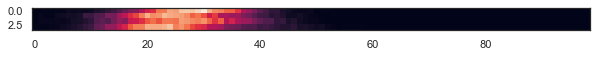

In [716]:
all_distances=np.array(df["distance_from_every_sem_center"].to_list())
distances_except_ship_auto=np.array(df["distance_from_every_sem_center"][((df["labels"] !=1) & (df["labels"] !=8))].to_list())
distances_only_ship_auto=np.array(df["distance_from_every_sem_center"][(df["labels"]==1) | (df["labels"] ==8)].to_list())

def arrays(distances,vector_centers):
    linear_bins=np.linspace(0,1,100)
    arrays=[]
    for idx in range(len(vector_centers)):
        counts_1, bins=np.histogram(distances[:,idx],bins=linear_bins,range=(0,1),density=True)
        arrays.append(counts_1/100.)
    return np.array(arrays)


def all_dists(distances,vector_centers):
    
    arrays=[]
    for idx in range(len(vector_centers)):
        arrays.append(distances[:,idx])
    return np.array(arrays)
    


plt.figure(figsize=(10,10))
plt.imshow(arrays(all_distances,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]])

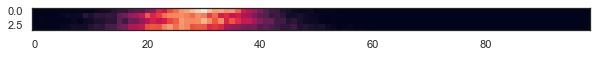

In [717]:
plt.figure(figsize=(10,10))
plt.imshow(arrays(distances_except_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]])

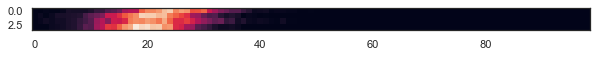

In [718]:
plt.figure(figsize=(10,10))
plt.imshow(arrays(distances_only_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]])

 !!! need to plot with same LUT for colors. to show clear difference. 
 data is not balanced, effect need to be done over time with a balance set.

[2, 3, 4, 7]
['bird', 'cat', 'deer', 'horse']


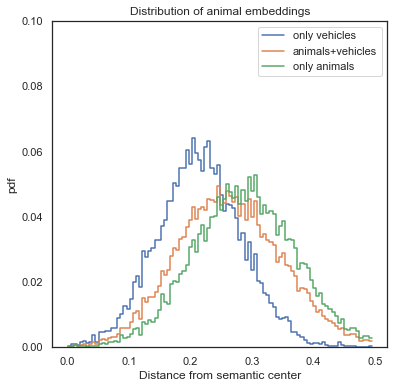

In [721]:
import numpy as np
import random
from matplotlib import pyplot as plt

# fixed bin size
lbs=[lb for idxe, lb in enumerate(labels_center) if lb not in set((1,8))]
print(lbs)
print([ classes[l] for l in lbs])
bins=np.linspace(0,0.5,100)
plt.figure(figsize=(6,6))
distrs=all_dists(all_distances,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
cnts_2,_=np.histogram(distrs.ravel(),bins=bins,density=True)
distrs_only_ship=all_dists(distances_only_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
cnts,_=np.histogram(distrs_only_ship.ravel(),bins=bins,density=True)
distrs_excpt_ship=all_dists(distances_except_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
cnts_3,_=np.histogram(distrs_excpt_ship.ravel(),bins=bins,density=True)
plt.step(bins[0:-1],  cnts/100.,label="only vehicles")
plt.step(bins[0:-1],  cnts_2/100.,label="animals+vehicles")
plt.step(bins[0:-1],  cnts_3/100.,label="only animals")
plt.title('Distribution of animal embeddings')
plt.xlabel('Distance from semantic center')
plt.ylabel('pdf')
plt.ylim(0,0.1)
plt.legend()
plt.show()


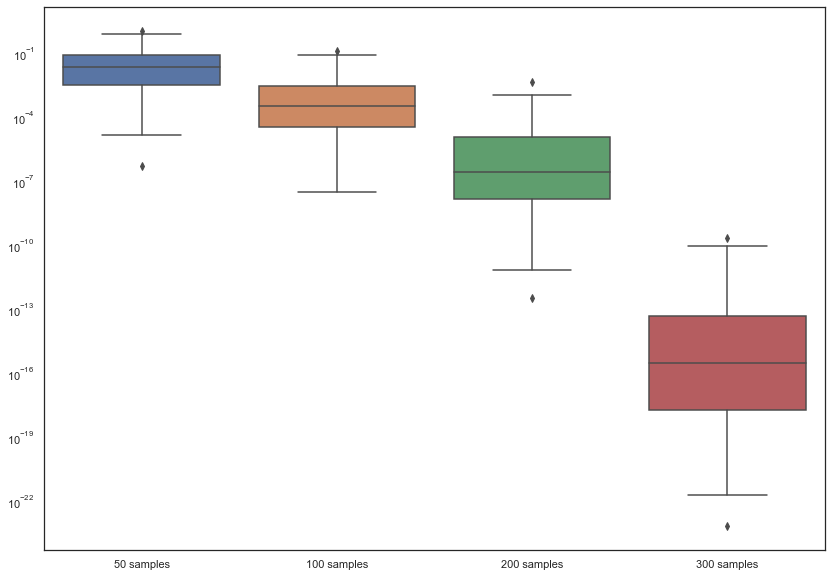

In [729]:
from scipy import stats
simulated_experiments= np.array([[stats.ks_2samp(np.random.choice(distrs_only_ship.ravel(), x), np.random.choice(distrs.ravel(),x)).pvalue for _ in range(100)] for x in (50,100,200,500)])
df = pd.DataFrame(simulated_experiments.T,
                  columns=['50 samples', '100 samples', '200 samples', '300 samples'])
# boxplot = df.boxplot(column=['50 samples', '100 samples', '200 samples', '300 samples'])

sns.boxplot(data = df,whis=[1, 99])
plt.yscale('log')


[2, 3, 4, 7]
['bird', 'cat', 'deer', 'horse']


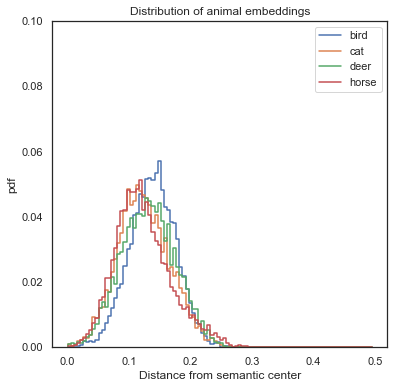

In [612]:
import numpy as np
import random
from matplotlib import pyplot as plt
dists = arrays(all_distances,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
# fixed bin size
lbs=[lb for idxe, lb in enumerate(labels_center) if lb not in set((1,8))]
print(lbs)
print([ classes[l] for l in lbs])
bins=np.linspace(0,0.5,100)
plt.figure(figsize=(6,6))
for idx, dist_n in enumerate(dists):
#     bins = np.arange(0, 1, 0.025) # fixed bin size

#     plt.xlim([min(dist_n)-0.2, max(dist_n)+0.2])
    
    plt.step(bins[0:-1], dist_n, label=classes[lbs[idx]])
    plt.title('Distribution of animal embeddings')
    plt.xlabel('Distance from semantic center')
    plt.ylabel('pdf')
    plt.ylim(0,0.1)

plt.legend()
plt.show()


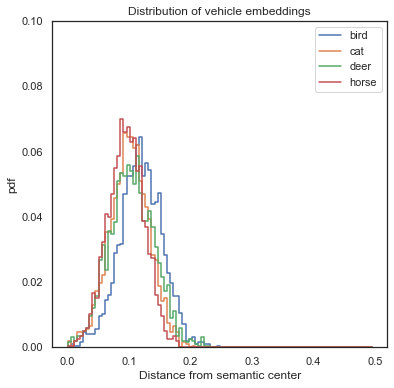

In [613]:
dists = arrays(distances_only_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
# fixed bin size
bins=np.linspace(0,0.5,100)
plt.figure(figsize=(6,6))
for idx,dist_n in enumerate(dists):
#     bins = np.arange(0, 1, 0.025) # fixed bin size

#     plt.xlim([min(dist_n)-0.2, max(dist_n)+0.2])

    plt.step(bins[0:-1], dist_n, label=classes[lbs[idx]])
    plt.title('Distribution of vehicle embeddings')
    plt.xlabel('Distance from semantic center')
    plt.ylabel('pdf')
    plt.ylim(0,0.1)


plt.legend()
plt.show()

## KS test in two dimensions

need to refer to my old paper for reference for code. 

In [385]:
from __future__ import division
import numpy as np
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

__all__ = ['ks2d2s', 'estat', 'estat2d']


def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic. Returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate, but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, Monthly Notices of the Royal Astronomical Society, vol. 202, pp. 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, Monthly Notices of the Royal Astronomical Society, vol. 225, pp. 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z


## Simpler Metric for drift measure in two dimensions

result should be correlated to ks test in 2 dimensions, provide a good metric to track. 
TODO: Describe cummulative distribution and relation to KS test.

## max cummulative distance

In [620]:
distribution_without_vehicles = arrays(distances_except_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
distribution_with_vehicles = arrays(all_distances,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]
distribution_with_only_vehicles = arrays(distances_only_ship_auto,semantic_centers)[[idx for idx, lb in enumerate(labels_center) if lb not in set((1,8))]]

In [621]:
def cummulative_distribition(tensor):
    return np.cumsum(np.cumsum(tensor,axis=1),axis=0)

In [626]:
np.max(cummulative_distribition(distribution_without_vehicles)- cummulative_distribition(distribution_with_vehicles))

4.440892098500626e-16

In [623]:
np.abs(np.max(cummulative_distribition(distribution_without_vehicles)- cummulative_distribition(distribution_with_only_vehicles)))

2.220446049250313e-16

In [625]:
np.abs(np.max(cummulative_distribition(distribution_with_vehicles)- cummulative_distribition(distribution_with_only_vehicles)))

2.220446049250313e-16

### Pair Correlations

Another particular method that should pinpoint any drift in the embedding distribution are pair correlations, or additional higher moments of the embedding locations.

To compute pair correlations we will first compute the dot product among every other embedding, notice while this is a computational intensive. The overall distribution of the values could be computed in batch as long as the we expect a uniform distribution per batch. 


In [427]:
from scipy.stats import binned_statistic_2d

In [426]:
# stream correlation

In [470]:
np.linspace(0,1,100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [478]:
full_histrogram,_=np.histogram([],bins=np.linspace(0,1,100))
   
for each_feature_1 in features_norm:       
    res,_ = np.histogram([np.dot(each_feature_1,each_feature_2) for each_feature_2 in features_norm] ,np.linspace(0,1,100))
    full_histrogram += res
    

In [479]:
full_histrogram

array([  74194,  102488,  137816,  182898,  240586,  310334,  389376,
        483026,  586020,  703336,  825890,  959088, 1094222, 1223110,
       1343688, 1456018, 1549538, 1626298, 1678830, 1702648, 1703624,
       1684336, 1637154, 1567998, 1482914, 1380468, 1270994, 1154430,
       1035138,  920988,  806086,  693964,  595444,  502770,  420044,
        347038,  284402,  229798,  184296,  146058,  114240,   88040,
         67736,   51120,   39324,   29166,   21674,   16016,   11864,
          8146,    6074,    4378,    3078,    2228,    1392,    1036,
           742,     558,     382,     236,     172,     144,     106,
            72,      38,      30,      48,      22,      20,      22,
            24,      22,      38,      14,      22,      12,      10,
             6,       2,       2,       4,       0,       6,       4,
             2,       2,       0,       0,       0,       0,       0,
             0,       0,       0,       6,      12,     170,     846,
          3353])

In [480]:
print(len(np.linspace(0,1,100)))
print(len(full_histrogram))

100
99


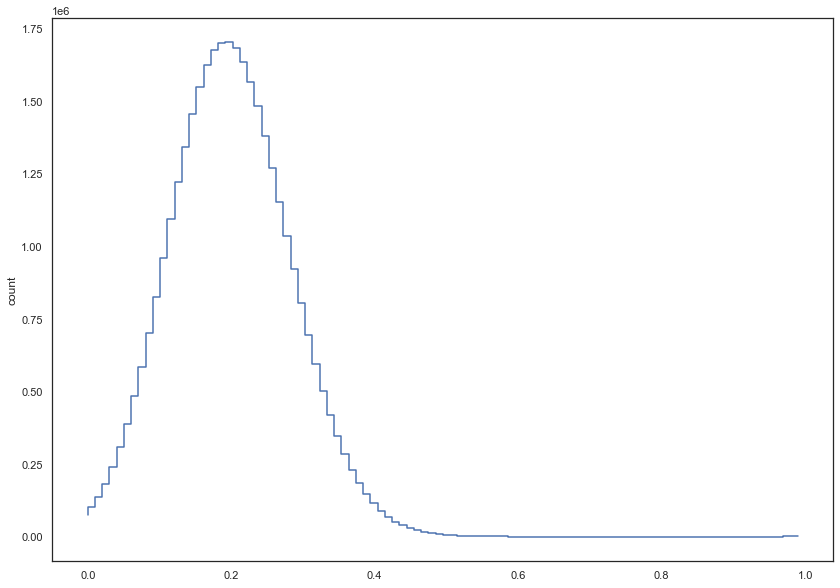

In [481]:
plt.step(np.linspace(0,1,100)[0:-1], full_histrogram)
plt.title('')
plt.xlabel('')
plt.ylabel('count')
plt.show()

In [488]:
(len(features_norm)**2)

35366809

In [ ]:
Vn(R) = 2 Vn-1(Rcos(θ))Rcos(θ)dθ

In [493]:
np.linspace(0,1,100)[1:]**2

array([1.02030405e-04, 4.08121620e-04, 9.18273646e-04, 1.63248648e-03,
       2.55076013e-03, 3.67309458e-03, 4.99948985e-03, 6.52994592e-03,
       8.26446281e-03, 1.02030405e-02, 1.23456790e-02, 1.46923783e-02,
       1.72431385e-02, 1.99979594e-02, 2.29568411e-02, 2.61197837e-02,
       2.94867871e-02, 3.30578512e-02, 3.68329762e-02, 4.08121620e-02,
       4.49954086e-02, 4.93827160e-02, 5.39740843e-02, 5.87695133e-02,
       6.37690032e-02, 6.89725538e-02, 7.43801653e-02, 7.99918376e-02,
       8.58075707e-02, 9.18273646e-02, 9.80512193e-02, 1.04479135e-01,
       1.11111111e-01, 1.17947148e-01, 1.24987246e-01, 1.32231405e-01,
       1.39679625e-01, 1.47331905e-01, 1.55188246e-01, 1.63248648e-01,
       1.71513111e-01, 1.79981635e-01, 1.88654219e-01, 1.97530864e-01,
       2.06611570e-01, 2.15896337e-01, 2.25385165e-01, 2.35078053e-01,
       2.44975003e-01, 2.55076013e-01, 2.65381084e-01, 2.75890215e-01,
       2.86603408e-01, 2.97520661e-01, 3.08641975e-01, 3.19967350e-01,
      

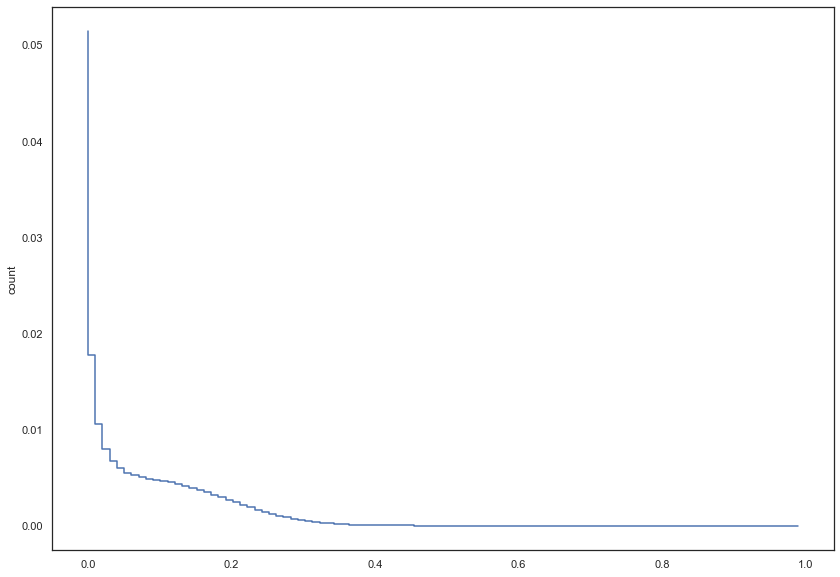

In [495]:
plt.step(np.linspace(0,1,100)[0:-1], full_histrogram/(len(features_norm)**2-len(features_norm))/2/np.linspace(0,1,100)[1:]**2/100/2)
plt.title('')
plt.xlabel('')
plt.ylabel('count')
plt.show()

## Testing animal only projection on UMAP for visualizations

In [370]:
animal_projections=np.array(df["animal_projections"][(df.labels!=1) & (df.labels!=8)].to_list())
animal_labels =df["labels"][(df.labels!=1) & (df.labels!=8)]
animal_semantic_centers_proj = np.array(df["projections"][(df.labels!=1) & (df.labels!=8) & df.semantic_center].to_list())
animal_semantic_center_labels= np.array( df["labels"][(df.labels!=1) & (df.labels!=8)& df.semantic_center].to_list())

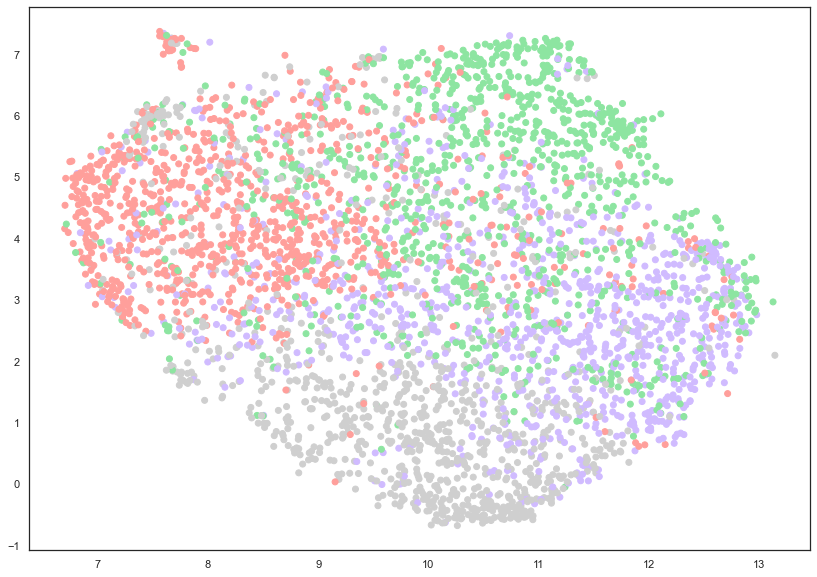

In [365]:
plt.scatter(
    animal_projections[:,0],
    animal_projections[:,1],
    c=[sns.color_palette("pastel")[clas] for clas in animal_labels ])

# for idx in range(len(animal_semantic_center_labels)):
#     plt.scatter(
#         animal_semantic_centers_proj[idx][0],
#         animal_semantic_centers_proj[idx][1],
#         c=[sns.color_palette()[animal_semantic_center_labels[idx]]],
#         marker='x',s=52)
#     plt.annotate(classes[animal_semantic_center_labels[idx]], animal_semantic_centers_proj[idx],
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      size=20, weight='bold',c=sns.color_palette()[animal_semantic_center_labels[idx]]) 
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the embeddings', fontsize=24)


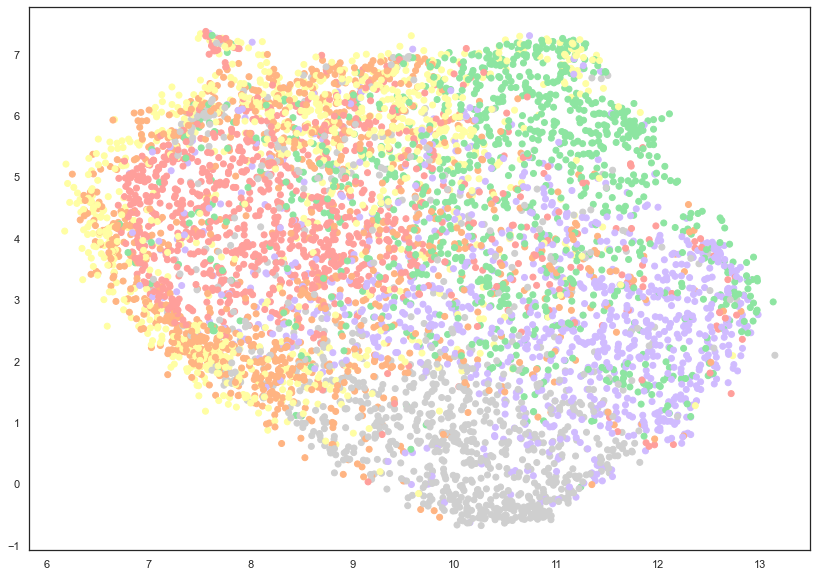

In [372]:
plt.scatter(
    np.array(df["animal_projections"].to_list())[:,0],
    np.array(df["animal_projections"].to_list())[:,1],
    c=[sns.color_palette("pastel")[clas] for clas in labels ])


## Full Projection for visualization

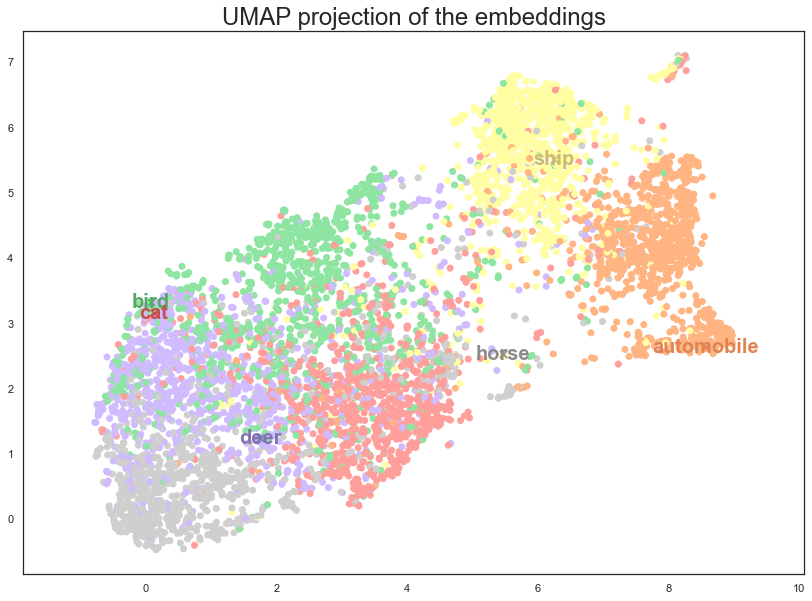

In [446]:
plt.scatter(
    projections[:, 0],
    projections[:, 1],
    c=[sns.color_palette("pastel")[clas] for clas in labels ])
for idx in range(len(semantic_centers_projections)):
    plt.scatter(
        semantic_centers_projections[idx][0],
        semantic_centers_projections[idx][1],
        c=[sns.color_palette()[labels_center[idx]]],
        marker='x',s=52)
    plt.annotate(classes[labels_center[idx]], semantic_centers_projections[idx],
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold',c=sns.color_palette()[labels_center[idx]]) 
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the embeddings', fontsize=24)
plt.grid(False)


Let's take a look at the distributions for their semantinc centers. They are certainly look further awya from the projection centers, in the image above. 

## Old visualizations using PCA 

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['features'] = features
df['labels'] = [x.item() for x in labels]

df_p = pd.DataFrame()
df_p['features'] = features_p
df_p['labels'] = [x.item() for x in labels_p]

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import pandas as pd

Let's plot the firt 2 components and annotate the location of each center:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in range(0,9):
    plt.annotate(i,
                 df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

Let's see if the points from the test set behave the way we expect to:

# Chaos

### Semantic Centers

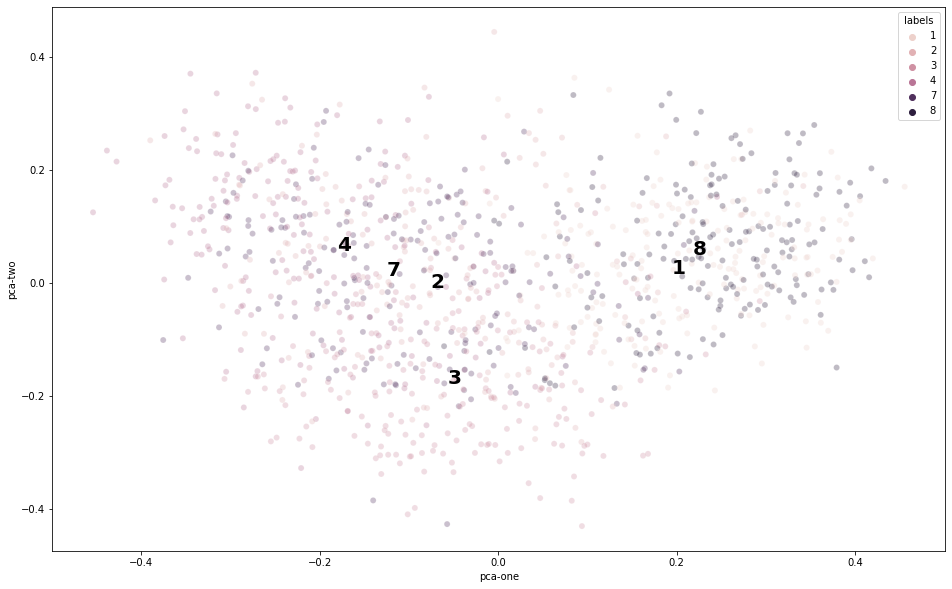

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df_p.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
#     palette=sns.color_palette("husl", 2),
    data=df_p.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in range(0,9):
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

Simulating a scenario where we only have images from one category:

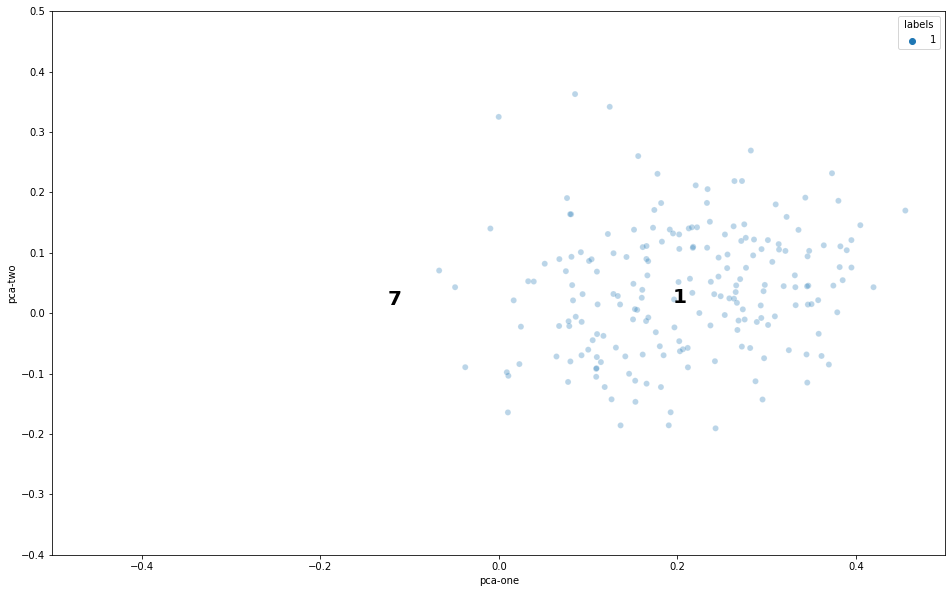

In [58]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# rndperm = np.random.permutation(df_p.shape[0])

# plt.figure(figsize=(16,10))
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.4, 0.5])
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="labels",
# #     palette=sns.color_palette("husl", 1),
#     data=df_p[df_p['labels']==1],
#     legend="full",
#     alpha=0.3
# )
# # Annotate center of each cluster
# for i in [1,7]:
#     plt.annotate(i, 
#                      df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      size=20, weight='bold') 

# Production Stage


Need to create mixed events for each date to show drift.

## Case 1 - Batch with only one group

Calculating the coordinates for centers of both groups `c1` and `c7`

In [59]:
features_1 = torch.stack([x for i,x in enumerate(features) if labels[i]==1 ])
for i in range(10):
    torch.stack([x for i,x in enumerate(features) if labels[i]==1 ])
    c1 = torch.mean(features_1,0)
c1.size()

torch.Size([1024])

In [60]:
features_7 = torch.stack([x for i,x in enumerate(features) if labels[i]==7 ])
c7 = torch.mean(features_7,0)
c7.size()

torch.Size([1024])

Calculating the distance (dot product) between each embedding in the test set and centers of both categories:

In [33]:
# Distances between train set and cluster centers
dist_1 = [torch.dot(x,c1).item() for x in features]
dist_7 = [torch.dot(x,c7).item() for x in features]

# dist_1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p)]
# dist_7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p)]

# Distances between test set, with only one category "Horse", and cluster centers
dist_p1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p) if labels_p[i]==7]
dist_p7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p) if labels_p[i]==7]

# dist_p1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p)]
# dist_p7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p)]


[0.17042507231235504,
 0.2129431962966919,
 0.22449064254760742,
 0.19598861038684845,
 0.13641376793384552,
 0.24507813155651093,
 0.27109554409980774,
 0.29645904898643494,
 0.25392580032348633,
 0.2755275368690491,
 0.2529647946357727,
 0.24741485714912415,
 0.30369818210601807,
 0.28904691338539124,
 0.307974636554718,
 0.19186410307884216,
 0.17146170139312744,
 0.17493374645709991,
 0.2829854488372803,
 0.32672762870788574,
 0.11368265002965927,
 0.21547073125839233,
 0.2925056219100952,
 0.29045313596725464,
 0.20046353340148926,
 0.18512819707393646,
 0.2699890732765198,
 0.16407379508018494,
 0.21265588700771332,
 0.27566927671432495,
 0.1452510952949524,
 0.23555594682693481,
 0.255568265914917,
 0.2698711156845093,
 0.1794980764389038,
 0.28451433777809143,
 0.25903356075286865,
 0.2590813934803009,
 0.27680379152297974,
 0.23209208250045776,
 0.15620943903923035,
 0.29912906885147095,
 0.2751310169696808,
 0.1759127378463745,
 0.14074420928955078,
 0.16620147228240967,
 0.1

<ipython-input-101-9478de30505b>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts_1, bins=np.histogram(dist_1,linear_bins,normed=True)
<ipython-input-101-9478de30505b>:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts_7, bins=np.histogram(dist_7,linear_bins,normed=True)
<ipython-input-101-9478de30505b>:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has

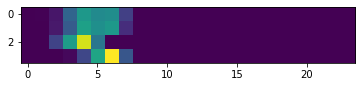

In [101]:
linear_bins=np.linspace(0,1,25)
counts_1, bins=np.histogram(dist_1,linear_bins,normed=True)
counts_7, bins=np.histogram(dist_7,linear_bins,normed=True)
counts_1_p, bins=np.histogram(dist_p1,linear_bins,normed=True)
counts_7_p, bins=np.histogram(dist_p7,linear_bins,normed=True)
plt.imshow(np.array([counts_1,counts_7,counts_1_p,counts_7_p]))
plt.show()

In [ ]:
def drift_computation():
    

In [77]:
print(len(counts_1))
len(np.diff(bins,1))

99


99

Plotting Histograms:
    - Train set x Cluster Center 1
    - Test set x Cluster Center 1
    - Train set x Cluster Center 7
    - Teste set x Cluster Center 7

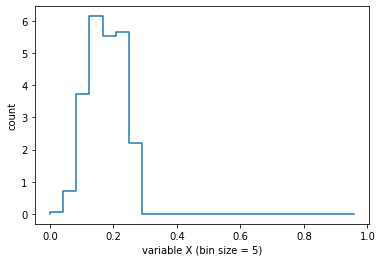

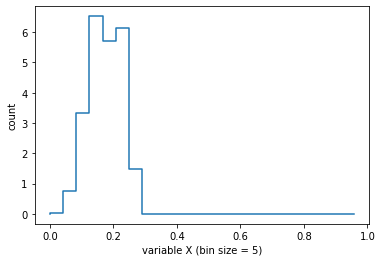

ValueError: x and y must have same first dimension, but have shapes (24,) and (1129,)

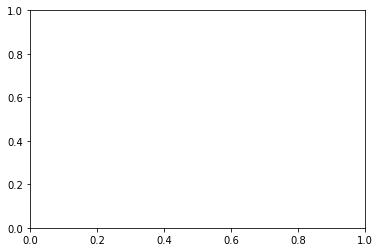

In [102]:
import numpy as np
import random
from matplotlib import pyplot as plt
dists = [counts_1,counts_7,counts_1_pta,dist_p7]
# fixed bin size
for dist_n in dists:
#     bins = np.arange(0, 1, 0.025) # fixed bin size

#     plt.xlim([min(dist_n)-0.2, max(dist_n)+0.2])

    plt.step(bins[0:-1], dist_n)
    plt.title('')
    plt.xlabel('variable X (bin size = 5)')
    plt.ylabel('count')

    plt.show()